In [40]:
import numpy as np
import pandas as pd
import sklearn
from pandas import DataFrame
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from scipy.stats import expon, reciprocal
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
#from bayes_opt import BayesianOptimization

Here we will put all the function at the same time, then after we will execute one after another our main

In [5]:
# Function to explore the data
def explore_data(df):
    print(df.describe())
    print(df.isnull().sum())
    print(df.dtypes)

# Function for feature engineering
def engineer_features(df):
    df['Hour'] = df['Date'].dt.hour
    df['DayOfWeek'] = df['Date'].dt.dayofweek # this is a panda function that give the nmber of the date (weeknd are 5, 6) Monday is 0
    df['Month'] = df['Date'].dt.month
    df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
    return df


# Function for data cleaning
def clean_data(df):
    df.fillna(df.mean(), inplace=True)  # Example: fill missing values with the mean
    # Add other data cleaning steps here
    return df

In [41]:
def show_correlation(df, target_variable):
    # Calculate the correlation matrix
    corr_matrix = df.corr()

    # Select correlations related to the target variable
    target_corr = corr_matrix[[target_variable]].sort_values(by=target_variable, ascending=False)

    # Create a figure
    plt.figure(figsize=(8, 10))

    # Plot heatmap of the sorted target variable correlations
    sns.heatmap(target_corr, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
    plt.title(f'Feature Correlation with {target_variable}')
    plt.show()

In [6]:
# Assuming 'Date' column or any datetime type columns are correctly excluded from X_to_scale
def transform_data1(df, target_column_name, exclude_from_scaling=None):
    if exclude_from_scaling is None:
        exclude_from_scaling = ['Date']

    # Ensure 'Date' column is also excluded if still present
    #df_numeric = df.select_dtypes(include=[np.number, 'bool'])  # 'bool' included if you have boolean types
    X = df.drop([target_column_name] + exclude_from_scaling, errors='ignore', axis=1) # exclude y
    y = df[target_column_name]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns) # you may ask why: After scaling, X_scaled is a NumPy array
    # without the column names, because the scaling operation returns a NumPy array. This line converts X_scaled back
    # into a pandas

    # Re-include the excluded features without scaling
    X_excluded = df[exclude_from_scaling].reset_index(drop=True)
    X_final = pd.concat([X_scaled_df, X_excluded], axis=1)
    print("Make sure transformation is well done:")
    print(X_final)
    return X_final, y

def transform_data(df, target_column_name, exclude_from_scaling=None):
    if exclude_from_scaling is None:
        exclude_from_scaling = []

    # Set 'Date' as the index if it's not already, assuming 'Date' is the name of your datetime column
    if 'Date' in df.columns:
        df.set_index('Date', inplace=True)

    # Ensure 'Date' column is excluded from scaling by not adding it to X
    X = df.drop([target_column_name] + exclude_from_scaling, errors='ignore', axis=1)
    y = df[target_column_name]

    scaler = StandardScaler()
    # Only scale columns that are not excluded
    X_scaled = scaler.fit_transform(X.select_dtypes(include=[np.number]))
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.select_dtypes(include=[np.number]).columns, index=X.index)

    # Re-include the excluded features without scaling
    X_excluded = df[exclude_from_scaling]
    X_final = pd.concat([X_scaled_df, X_excluded], axis=1)

    print("Make sure transformation is well done:")
    print(X_final.head())
    return X_final, y

In [7]:
# Function to split the data, but this shouldn't be applied for time series as it supposes the variables as random
def split_data1(X, y, test_size=0.2, random_state=203):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test


def split_data(X, y, dates, test_size=0.2):
    split_point = int(len(X) * (1 - test_size))
    X_train, X_test = X[:split_point], X[split_point:]
    y_train, y_test = y[:split_point], y[split_point:]
    dates_train, dates_test = dates[:split_point], dates[split_point:]
    return X_train, X_test, y_train, y_test, dates_train, dates_test

Use the Multiple Splits Function: This function is beneficial for thoroughly testing and validating your model across different time windows. It provides insights into how the model performs as more data becomes available, and helps you understand how stable and robust your model is under varying conditions. \\ 
Objective: Use this approach to adjust hyperparameters, try different model architectures, and test different feature sets to see how changes affect performance across multiple time periods.
Advantage: This method provides a comprehensive view of model performance and helps ensure that your model is not overfitting to a specific time period.

Use the Single Last Split Function: Once you are satisfied with your model's performance and have finalized your tuning, switch to using the function that returns only the last split. This setup maximizes the amount of training data you use and tests the model on the most recent data, which is typically what you'd do in a production environment or for a final evaluation before deployment.
Objective: Prepare the model for real-world application by training it on the fullest extent of historical data available and evaluating it on the most recent, unseen data segment.
Advantage: Maximizes the use of available data and provides a realistic assessment of how the model will perform when making actual forecasts after deployment.

In [8]:
def time_series_split(X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    train_indices = []
    test_indices = []
    X_train, X_test, y_train, y_test = None, None, None, None

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        # Collect all train and test indices
        train_indices.append(train_index)
        test_indices.append(test_index)

    return X_train, X_test, y_train, y_test, train_indices, test_indices

In [9]:
###
    # we start with SVR, but it will works with others models
def train_model(X_train, y_train, technique, params):
    """
    Trains an SVR model based on the specified technique and parameters.

    :param X_train: Training feature dataset.
    :param y_train: Training target dataset.
    :param technique: Specifies the technique to use.
                      "SVR default" for default parameters, "SVR" for custom parameters.
    :param params: Dictionary of parameters for the SVR model.
    :return: Trained SVR model.
    """
    if technique == "SVR default":
        model = SVR()
    elif technique == "SVR":
        model = SVR(**params)
    else:
        raise ValueError("Unsupported technique specified.")

    model.fit(X_train, y_train)
    return model

In [10]:
def evaluate_model(model, X_test, y_test):
    """

    :type model: this is a trained model, and it's coming from the returned value of train_model
    """
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)

    # Print the evaluation metrics
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"Root Mean Squared Error: {rmse}")
    print(f"R^2 Score: {r2}")

    return predictions, mse, mae, rmse, r2

In [11]:
def perform_grid_search(X_train, y_train):  # i don't like it. it only works with SVR, but we will leave it to later
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto'],
        'kernel': ['rbf']
    }
    grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_

In [12]:
def perform_random_search(X_train, y_train, model, param_dist, n_iter=100):
    random_search = RandomizedSearchCV(model, param_distributions=param_dist,
                                       n_iter=n_iter, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=203)
    random_search.fit(X_train, y_train)
    return random_search.best_params_, random_search.best_score_

In [13]:
def tune_hyperparameters(X_train, y_train, model, param_grid):
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_params_, grid_search.best_score_

In [14]:
def plotting1(predictions, y_test):
    plt.figure(figsize=(14, 7))
    plt.plot(predictions, label='Predicted', alpha=0.7)
    plt.plot(y_test.values, label='Actual', alpha=0.5)  # Ensure y_test is a series, so we access .values
    plt.title('Actual vs. Predicted Values Over Time')
    plt.xlabel('Time/Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

def plotting(predictions, y_test, dates):
    plt.figure(figsize=(14, 7))
    plt.plot(dates, predictions, label='Predicted', alpha=0.7)  # Use dates on the x-axis
    plt.plot(dates, y_test, label='Actual', alpha=0.5)  # Ensure y_test is plotted with dates
    plt.title('Actual vs. Predicted Values Over Time')
    plt.xlabel('Date')
    plt.ylabel('Day Ahead Auction Price')
    plt.legend()
    plt.xticks(rotation=45)  # Rotate date labels for better visibility
    plt.tight_layout()  # Adjust layout to make room for label rotation
    plt.show()
'''
here we had problems in plotting. this plotting method isn't adapted for time series split and also we weren't indexing the dates
'''

"\nhere we had problems in plotting. this plotting method isn't adapted for time series split and also we weren't indexing the dates\n"

In [15]:
def plot_all_folds(model, X, y, test_indices):
    plt.figure(figsize=(14, 7))
    for index in test_indices:
        # Make predictions for each test set
        X_test = X.iloc[index]
        y_test = y.iloc[index]
        predictions = model.predict(X_test)

        # Plot
        plt.plot(X_test.index, predictions, label='Predicted', alpha=0.7)
        plt.plot(X_test.index, y_test, label='Actual', alpha=0.5)
    
    plt.title('Actual vs. Predicted Values Over Time')
    plt.xlabel('Date')
    plt.ylabel('Day Ahead Auction Price')
    plt.legend()
    plt.show()

In [16]:

def plot_training_testing(model, X, y, train_indices, test_indices):
    plt.figure(figsize=(15, 8))

    # Configure the x-axis to better handle dates
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    
    # Plot a subset or downsample
    subset_size = 1000  # Adjust as needed for visibility
    for train_idx in train_indices:
        X_train = X.iloc[train_idx].iloc[-subset_size:]
        y_train = y.iloc[train_idx].iloc[-subset_size:]
        plt.plot(X_train.index, y_train, 'b-', label='Training data' if train_idx is train_indices[0] else "", alpha=0.1)
    
    for test_idx in test_indices:
        X_test = X.iloc[test_idx]
        y_test = y.iloc[test_idx]
        predictions = model.predict(X_test)
        plt.plot(X_test.index, y_test, 'g-', label='Actual Test' if test_idx is test_indices[0] else "", alpha=0.5)
        plt.plot(X_test.index, predictions, 'r--', label='Predicted Test' if test_idx is test_indices[0] else "", alpha=0.5)

    plt.title('Model Performance on Training and Testing Data')
    plt.xlabel('Date')
    plt.ylabel('Day Ahead Auction Price')
    plt.legend()
    plt.xticks(rotation=45)  # Rotate date labels for better visibility
    plt.tight_layout()  # Adjust layout to ensure no label cut-off
    plt.show()

In [17]:
# this plotting only show the last testing phase, which the only interesting part 
def plot_last_test_set_predictions(model, X, y, train_indices, test_indices):
    # Get the last test index
    last_test_index = test_indices[-1]

    # Extract the last test set
    X_test = X.iloc[last_test_index]
    y_test = y.iloc[last_test_index]

    # Predict on the last test set
    predictions = model.predict(X_test)

    # Plot
    plt.figure(figsize=(14, 7))
    plt.plot(X_test.index, predictions, label='Predicted', alpha= 0.7)
    plt.plot(X_test.index, y_test, label='Actual', alpha= 0.5)
    

    # Format the x-axis to handle dates better
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gcf().autofmt_xdate()  # Auto-rotates the date labels

    plt.title('Actual vs. Predicted Values on the Last Testing Set')
    plt.xlabel('Date')
    plt.ylabel('Day Ahead Auction Price')
    plt.legend()
    plt.tight_layout()  # Adjust layout to ensure no label cut-off
    plt.show()
# Make sure to use the correct model, features 'X_scaled', target 'y', and the indices 'train_indices', 'test_indices

bissmillah let's run

In [18]:
path_bureau= r'H:\perso\thesis\data\germany_2023.xlsx'
path_home = '/Users/mohamedabdellahi/Desktop/Trust the process/1- M203/master thesis/data/germany-Main.xlsx'
path= path_home
target_column_name= 'Day Ahead Auction'
df = pd.read_excel(path, skiprows=[1])
explore_data(df)

                                Date  Cross border electricity trading  \
count                           8760                       8760.000000   
mean   2023-07-02 12:05:40.684931840                       1339.493233   
min              2023-01-01 00:00:00                     -19226.890000   
25%              2023-04-02 06:45:00                      -3548.647500   
50%              2023-07-02 12:30:00                       1590.575000   
75%              2023-10-01 18:15:00                       6687.985000   
max              2023-12-31 23:00:00                      17081.870000   
std                              NaN                       6958.835067   

           Nuclear  Non-Renewable     Renewable          Load  \
count  2519.000000    8760.000000   8760.000000   8760.000000   
mean   2671.735395   18984.858203  29720.436555  52246.634053   
min     271.760000    5911.920000   7956.630000  30908.880000   
25%    2410.400000   11938.817500  18863.142500  44765.217500   
50%    2

In [19]:
df= engineer_features(df)
print(df.head())

                 Date  Cross border electricity trading  Nuclear  \
0 2023-01-01 00:00:00                         -12557.67  2459.17   
1 2023-01-01 01:00:00                         -15382.58  2458.60   
2 2023-01-01 02:00:00                         -16357.50  2459.64   
3 2023-01-01 03:00:00                         -14005.92  2460.48   
4 2023-01-01 04:00:00                         -14544.00  2460.80   

   Non-Renewable  Renewable      Load  Day Ahead Auction  \
0        9146.69   38384.86  38536.48              -5.17   
1        8925.66   39415.38  37935.26              -1.07   
2        8902.44   39610.49  37103.11              -1.47   
3        8901.05   37023.62  36139.27              -5.08   
4        8863.19   36499.65  35711.44              -4.49   

   CO2 Emission Allowances, Auction DE  CO2 Emission Allowances, Auction EU  \
0                                83.41                                 84.1   
1                                83.41                                 8

In [20]:
df = clean_data(df)
            #centrer et reduire
X_scaled, y = transform_data(df, target_column_name, ['Hour', 'DayOfWeek', 'Month', 'IsWeekend'])
            #splitting the data
#X_train, X_test, y_train, y_test = time_series_split(X_scaled, y)
X_train, X_test, y_train, y_test, dates_train, dates_test = time_series_split(X_scaled, y, n_splits=5)

Make sure transformation is well done:
                     Cross border electricity trading   Nuclear  \
Date                                                              
2023-01-01 00:00:00                         -1.997167 -1.256802   
2023-01-01 01:00:00                         -2.403136 -1.260173   
2023-01-01 02:00:00                         -2.543242 -1.254023   
2023-01-01 03:00:00                         -2.205296 -1.249057   
2023-01-01 04:00:00                         -2.282623 -1.247165   

                     Non-Renewable  Renewable      Load  \
Date                                                      
2023-01-01 00:00:00      -1.094008   0.683074 -1.513693   
2023-01-01 01:00:00      -1.118586   0.764317 -1.580071   
2023-01-01 02:00:00      -1.121168   0.779699 -1.671946   
2023-01-01 03:00:00      -1.121323   0.575759 -1.778361   
2023-01-01 04:00:00      -1.125533   0.534451 -1.825596   

                     CO2 Emission Allowances, Auction DE  \
Date             

In [21]:
param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': [0.001, 0.01, 0.1, 1],
        'epsilon': [0.1, 0.2, 0.5, 0.3]
}


In [22]:
# Specify distributions rather than a list of options
param_dist = { # for random research
    'C': reciprocal(0.1, 1000),
    'gamma': expon(scale=1.0),
    'epsilon': [0.01, 0.1, 0.2, 0.5, 1]
}

In [23]:
#######------------------- Model training and evaluation
# Hyperparameter tuning
start_timeCalibration= time.time()
best_params, best_score = tune_hyperparameters(X_train, y_train, SVR(), param_grid)
end_timeCalibration = time.time()
calibration_time = end_timeCalibration - start_timeCalibration

In [24]:
print(f"Calibration time for Grid Research: {calibration_time} seconds")

Calibration time for Grid Research: 96.12143993377686 seconds


In [25]:
start_timeCalibrationRnd = time.time()
best_paramsRandom, best_scoreRandom = perform_random_search(X_train, y_train, SVR(), param_dist, n_iter=100)
end_timeCalibrationRnd = time.time()
calibration_timeRnd = end_timeCalibrationRnd - start_timeCalibrationRnd
print(f"Calibration time for Random search: {calibration_timeRnd} seconds")

Calibration time for Random search: 526.4615747928619 seconds


In [26]:
start_time_training= time.time()
model= train_model(X_train, y_train,"SVR", best_params)   #here we train the model
model2 = train_model(X_train, y_train, "SVR", best_paramsRandom)
end_time_training = time.time()
training_time = end_time_training - start_time_training
print(f"Training time: {training_time} seconds")

Training time: 2.672621011734009 seconds


In [27]:
predictions, mse, mae, rmse, r2= evaluate_model(model, X_test, y_test)

Mean Squared Error: 350.23327404663837
Mean Absolute Error: 14.734377231623641
Root Mean Squared Error: 18.714520406535627
R^2 Score: 0.8368810793436916


In [28]:
print(f"model with random search")
evaluate_model(model2, X_test, y_test)

model with random search
Mean Squared Error: 432.8301644636551
Mean Absolute Error: 14.428189159651227
Root Mean Squared Error: 20.804570758937928
R^2 Score: 0.7984121027706748


(array([62.4889024 , 67.60534461, 79.76335536, ..., 67.36216388,
        64.19151913, 61.58973501]),
 432.8301644636551,
 14.428189159651227,
 20.804570758937928,
 0.7984121027706748)

In [29]:
predictions1, mse1, mae1, rmse1, r2= evaluate_model(model2, X_test, y_test)

Mean Squared Error: 432.8301644636551
Mean Absolute Error: 14.428189159651227
Root Mean Squared Error: 20.804570758937928
R^2 Score: 0.7984121027706748


In [33]:
def autocorrel(target_column, lag, title="Autocorrelation Function"):
    plot_acf(target_column, lags= lag)  # Adjust the number of lags as needed
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.title(title)
    plt.show()

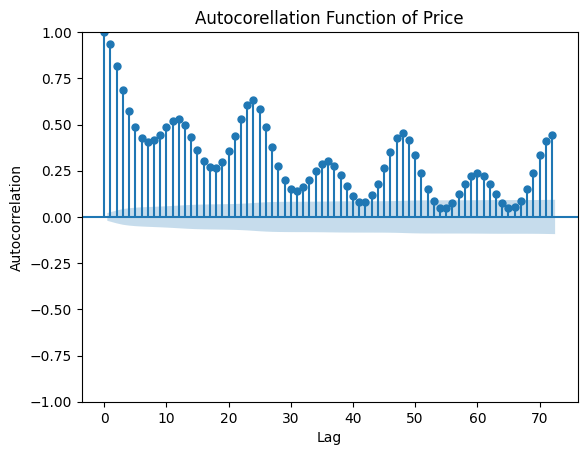

In [34]:
autocorrel(df["Day Ahead Auction"], 72, "Autocorellation Function of Price")

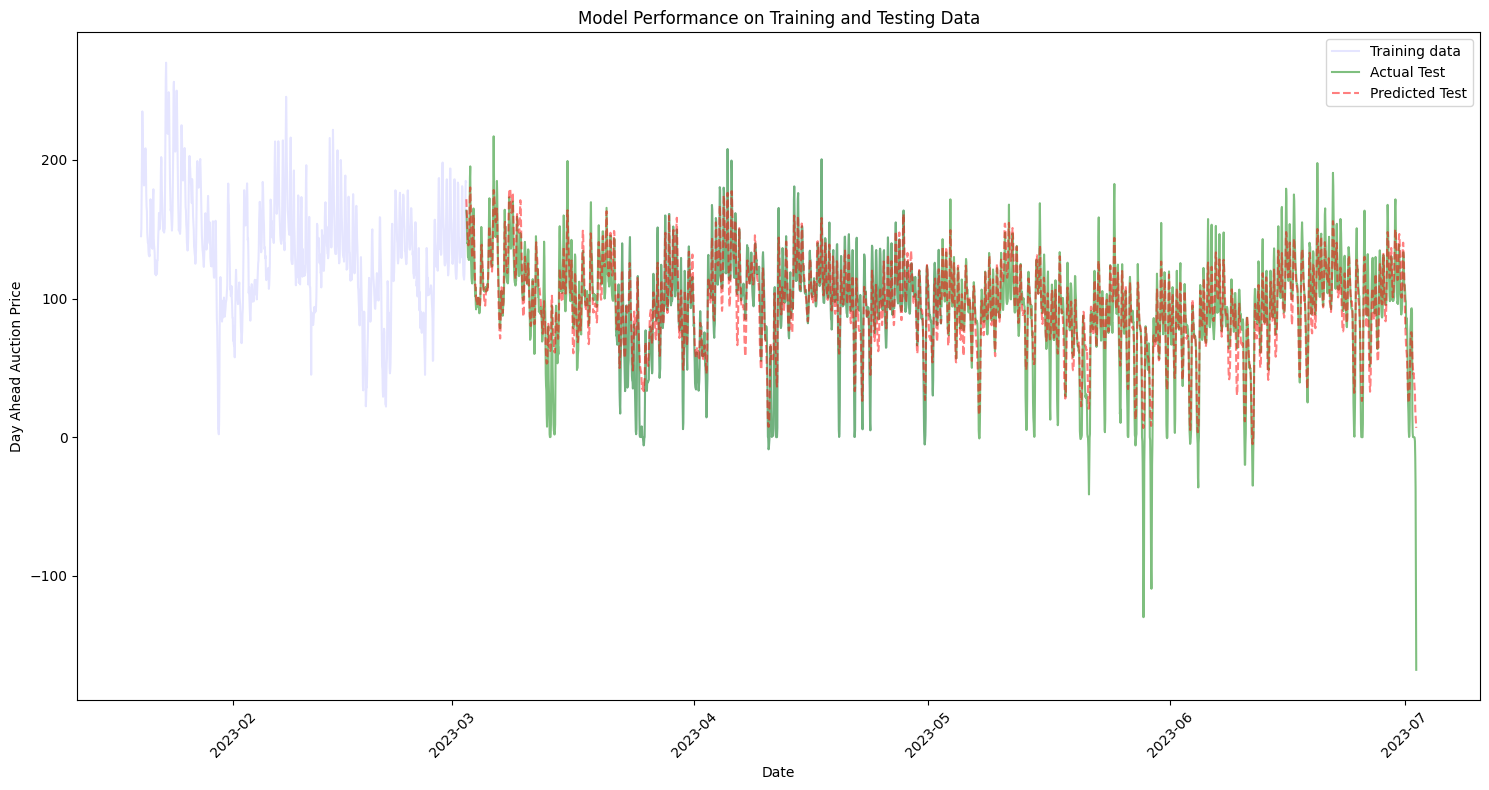

In [35]:
plot_training_testing(model, X_scaled, y, dates_train[:2], dates_test[:2])  # Example for first two splits

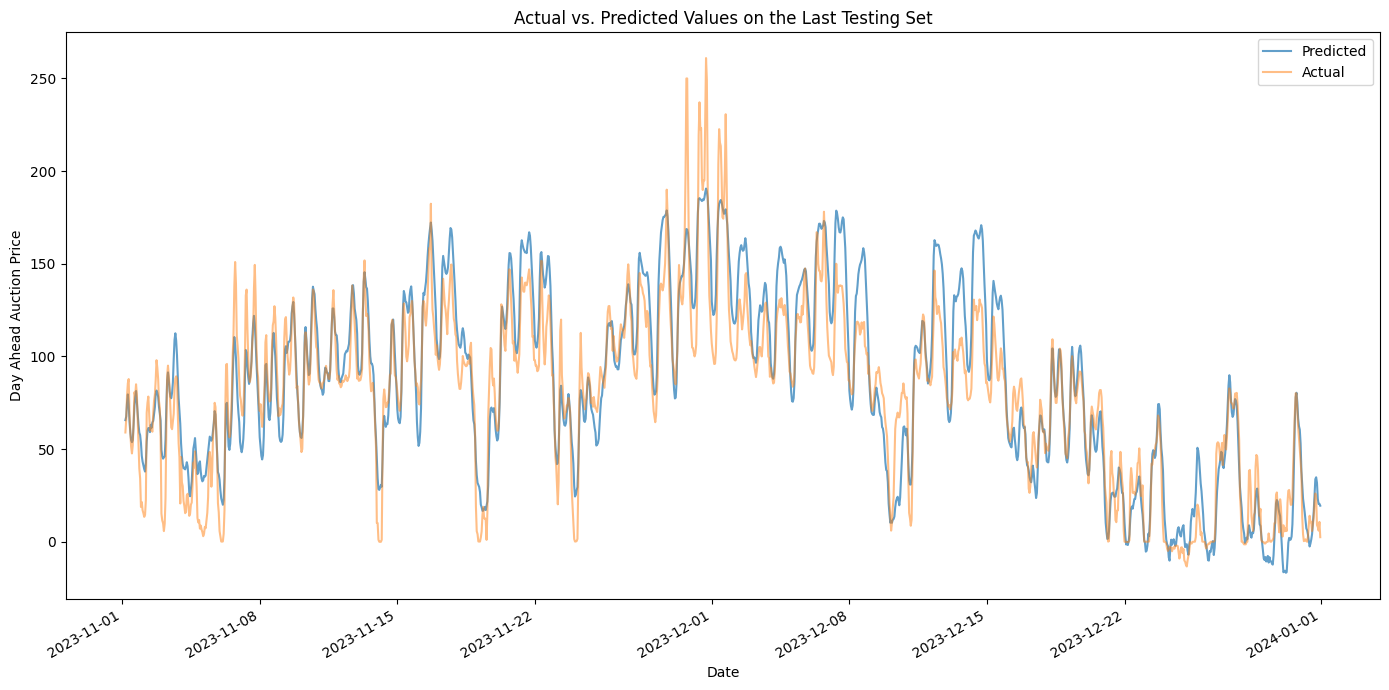

In [36]:
plot_last_test_set_predictions(model, X_scaled, y, dates_train, dates_test)

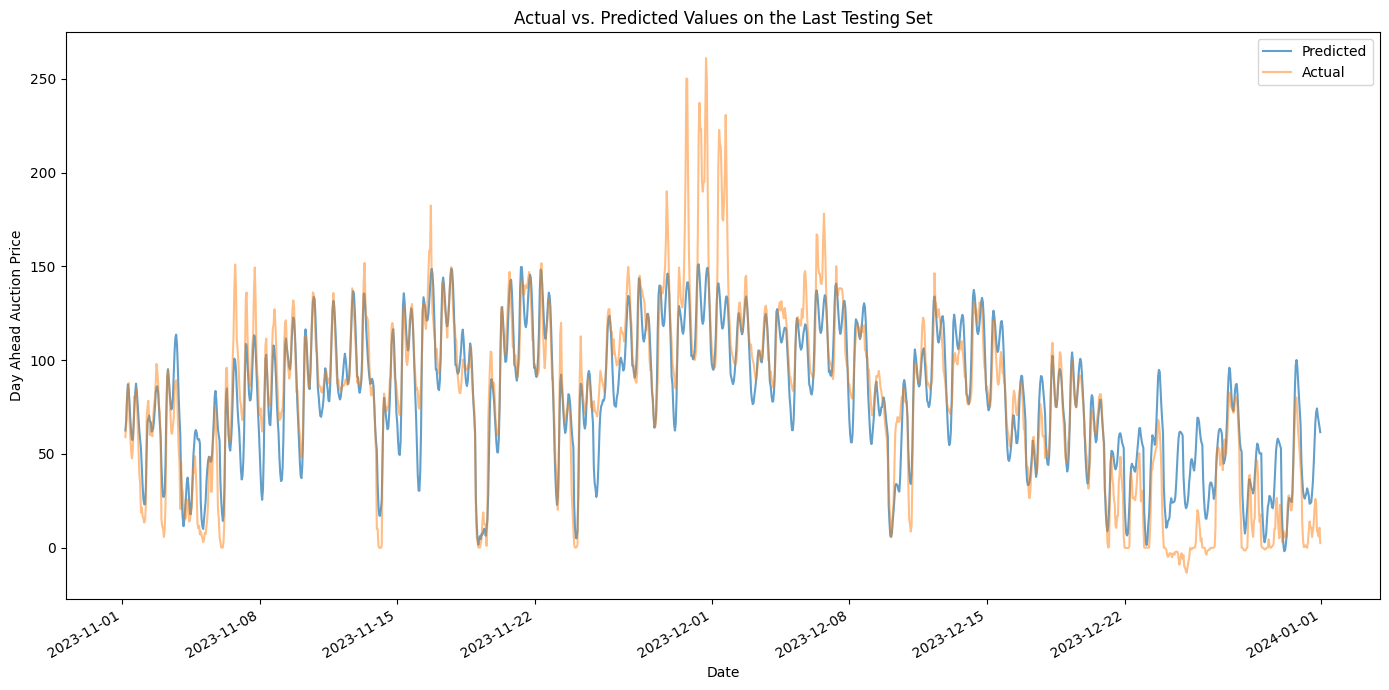

In [37]:
plot_last_test_set_predictions(model2, X_scaled, y, dates_train, dates_test)

We remark that the model with random search got better R2 and better MAE, but it fails to predict the spikes 

Let's get back to something that we had to do before. look at the correalation between teh price and teh features


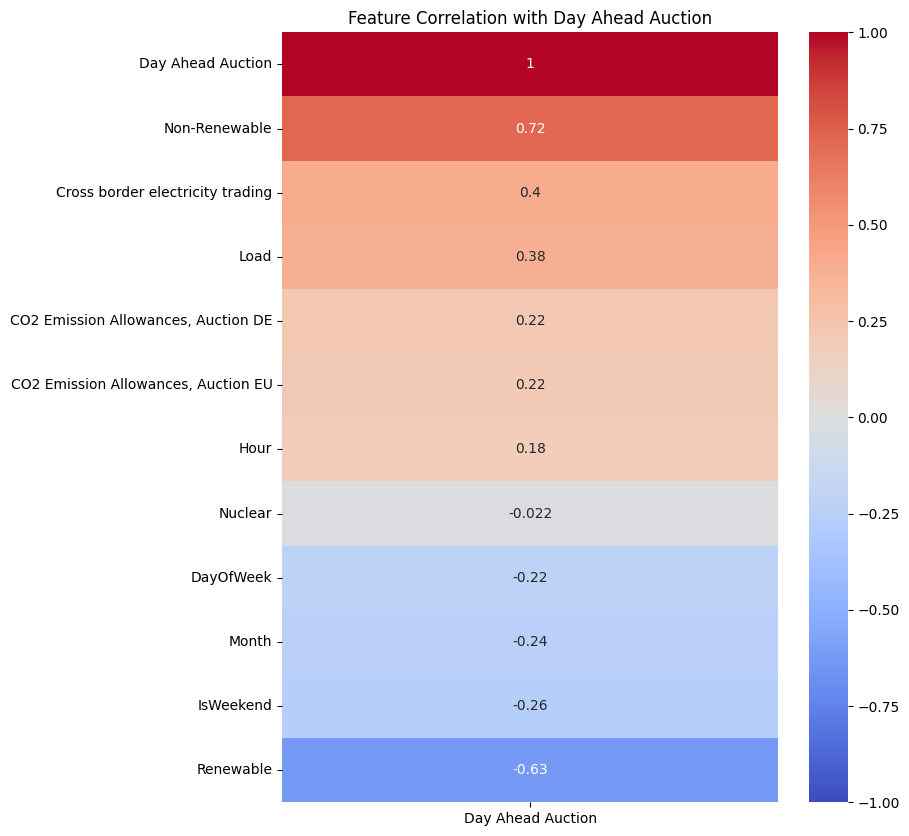

In [42]:
show_correlation(df, 'Day Ahead Auction')